# Разведочный анализ датасета изображений овощей "Vegetable Images"

**Цели ноутбука:**   
* Провести анализ характеристик изображений
* Провести анализ метаданных изображений
* Провести визуальный анализ изображений
* Визуализировать данные
* Провести первичную предобработку
* Сделать выводы по структуре данных

Датасет взят отсюда: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset?select=Vegetable+Images

In [57]:
# Для работы с EXIF-данными картинок
!pip install exif

In [58]:
import zipfile
import os

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image, ImageOps
import random
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

# Для работы с EXIF-данными картинок
import exif

In [59]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset", "Vegetable Images")
os.makedirs(DATASET_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Распаковка архива
with zipfile.ZipFile(os.path.join(DRIVE_DIR, "VegetableImages.zip"), "r") as zip_ref:
    zip_ref.extractall("./dataset")

# Проверим структуру папок
os.listdir(DATASET_DIR)

['Bottle_Gourd',
 'Papaya',
 'Radish',
 'Cauliflower',
 'Bitter_Gourd',
 'Carrot',
 'Pumpkin',
 'Cabbage',
 'Brinjal',
 'Capsicum',
 'Tomato',
 'Cucumber',
 'Potato',
 'Broccoli',
 'Bean']

In [61]:
# Список классов
classes = os.listdir(DATASET_DIR)
class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in classes}

print(f"Классы: {', '.join(classes)}")

Классы: Bottle_Gourd, Papaya, Radish, Cauliflower, Bitter_Gourd, Carrot, Pumpkin, Cabbage, Brinjal, Capsicum, Tomato, Cucumber, Potato, Broccoli, Bean


## 1. Анализ характеристик изображений

### Средние, минимальные и максимальные размеры изображений

Нахождение среднего, минимального и максимального размера изображений поможет определить оптимальный размер для последующей обработки. Получим размеры изображений и рассчитаем средние, минимальные и максимальные размеры.

In [62]:
# Функция для возврата списка строк вида [класс, имя файла, ширина, высота]
def check_image_sizes(folder_path, cls):
    sizes = []
    for img in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, img))
        sizes.append([cls, img, *image.size])
    return sizes

In [63]:
# Соберу строки с инофрмацией о размерах, пройдясь по папкам классов
row_list = []
for cls in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cls)
    row_list.extend(check_image_sizes(folder_path, cls))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/15 [00:00<?, ?it/s]

Строки имеют вид:
['Bottle_Gourd', '1178.jpg', 224, 224]


In [64]:
df = pd.DataFrame(row_list, columns=["class", "name", "width", "height"])
df.describe()

width        height
count  21000.0  21000.000000
mean     224.0    223.991333
std        0.0      0.467854
min      224.0    187.000000
25%      224.0    224.000000
50%      224.0    224.000000
75%      224.0    224.000000
max      224.0    224.000000

У всех изображений ширина равна 224px. Большая часть изображений имеет высоту 224px.

Рассмотрим подробнее:

In [65]:
df["width"].unique(), df["height"].unique()

(array([224]), array([224, 210, 211, 207, 223, 187, 198, 205, 200, 193]))

In [66]:
df[df["height"] != 224]

class      name  width  height
1411        Papaya  0741.jpg    224     210
1774        Papaya  0126.jpg    224     211
1885        Papaya  1246.jpg    224     207
2148        Papaya  1150.jpg    224     223
2687        Papaya  1138.jpg    224     187
2701        Papaya  0176.jpg    224     198
5712  Bitter_Gourd  0526.jpg    224     205
5958  Bitter_Gourd  0609.jpg    224     200
6396  Bitter_Gourd  0430.jpg    224     193

*Основная часть картинок размером 224 на 224 px, но встречаются картинки другого размера.*  
**Для ширины среднее значение, минимальное и максимальное совпадает - 224   
Для высоты среднее значение ~224, максимальное - 224, минимальное - 187**  
Присутствуют картинки с высотой другого размера в классе Papaya и Bitter_Gourd.  

**Самая подходящая ширина и высота для картинок - 224x224px.  
При изменении размера картинок с другой высоторй качество данных не пострадает, т.к. таких изображений немного (9шт из 21000) и значения высоты отличается от 224px не сильно (изображения не потеряют в детализации)**

### Средние значения и отклонения по каналам (R, G, B)

Средние значения по каналам могут быть использованы для нормализации изображений, что улучшает обучение моделей.  
Вычислим среднее и стандартное отклонение по каждому из трех каналов (красный, зеленый, синий) для всех изображений.

In [67]:
# Функция для возврата списка строк вида [класс, имя файла, среднее отклонение rgb, стандартное отклонение rgb]
def check_image_color(folder_path, cls):
    colors = []
    for img in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, img))
        b, g, r = cv2.split(image)
        r_mean, g_mean, b_mean = np.mean(r), np.mean(g), np.mean(b)
        r_std, g_std, b_std = np.std(r), np.std(g), np.std(b)
        colors.append([cls, img, r_mean, g_mean, b_mean, r_std, g_std, b_std])
    return colors

In [68]:
# Соберу строки с инофрмацией о RGB, пройдясь по папкам классов
row_list = []
for cls in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cls)
    row_list.extend(check_image_color(folder_path, cls))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/15 [00:00<?, ?it/s]

Строки имеют вид:
['Bottle_Gourd', '1178.jpg', 85.44256218112245, 117.14313616071429, 68.37440210459184, 49.01256567527335, 60.50026353394876, 49.72004182453455]


In [69]:
rgb_df = pd.DataFrame(
    row_list, columns=["class", "name", "mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"]
)
rgb_df.describe()

mean_R        mean_G        mean_B         std_R         std_G  \
count  21000.000000  21000.000000  21000.000000  21000.000000  21000.000000   
mean     119.337509    118.151408     87.348927     51.914656     52.396519   
std       27.391601     23.980795     33.588930     11.997966     10.794314   
min       45.794922     26.465840     11.900550     10.121523     12.691663   
25%       98.418253    106.007215     61.782501     46.314204     46.744917   
50%      114.738799    117.365055     82.310258     52.606615     53.218768   
75%      135.268495    130.212836    108.718416     58.575754     59.088941   
max      251.624821    251.437480    244.118324    109.484768    111.737861   

              std_B  
count  21000.000000  
mean      50.148858  
std       14.377823  
min       10.692505  
25%       40.683373  
50%       47.685299  
75%       56.861012  
max      119.839496

In [70]:
rgb_rows = []

channels = ["Red", "Green", "Blue"]
for cls in rgb_df["class"].unique():
    rows = rgb_df[rgb_df["class"] == cls].values
    mean_r = np.mean(rows[:, 2])
    mean_g = np.mean(rows[:, 3])
    mean_b = np.mean(rows[:, 4])
    std_r = np.std(rows[:, 5])
    std_g = np.std(rows[:, 6])
    std_b = np.std(rows[:, 7])
    means = [mean_r, mean_g, mean_b]
    stds = [std_r, std_g, std_b]
    rgb_rows.append([cls, mean_r, mean_g, mean_b, std_r, std_g, std_b])
    # Построим бар-график для среднего значения и стандартного отклонения
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=channels,
            y=[mean_r, mean_g, mean_b],
            error_y={"type": "data", "array": [std_r, std_g, std_b], "visible": True},
            marker={"color": ["red", "green", "blue"]},
            opacity=0.7,
        )
    )
    fig.update_layout(
        title=f"Среднее значение и стандартное отклонение по каналам (R, G, B) {cls}",
        xaxis_title="Каналы",
        yaxis_title="Значение пикселей",
        width=900,
        height=500,
    )
    fig.show()

**Заметно, что среднее значение стандартное отклонение сильно варьируется от класса к классу.** Для нормализации изображений можно использовать эти средние значения и стандартные отклонения по каждому каналу и классу, что повысит устойчивость модели к различиям в цветах между классами.

## 2. Анализ метаданных изображений

In [71]:
# Вернет строки вида [класс, имя файла, модель фотоаппарата, значение диафрагмы, значение яркости, фокусное расстояние, коэф. цифрового масштабирования]
def check_exif_data(folder_path, cls):
    exif_rows = []
    for img in os.listdir(folder_path):
        try:
            image = exif.Image(os.path.join(folder_path, img))
            if image.has_exif:
                # Добавляю модель фотоаппарата, значение диафрагмы, яркость, фокус, цифр. масштабирование
                exif_rows.append(
                    [
                        cls,
                        img,
                        image.get("model"),
                        image.get("aperture_value"),
                        image.get("brightness_value"),
                        image.get("focal_length"),
                        image.get("digital_zoom_ratio"),
                    ]
                )
            else:
                exif_rows.append([cls, img, None, None, None, None, None])
        except:
            print("Не удалось прочитать EXIF")
            exif_rows.append([cls, img, None, None, None, None, None])
    return exif_rows

In [72]:
# Соберу строки с инофрмацией о EXIF, пройдясь по папкам классов
exif_rows = []
for cls in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cls)
    exif_rows.extend(check_exif_data(folder_path, cls))

  0%|          | 0/15 [00:00<?, ?it/s]

Не удалось прочитать EXIF


/usr/local/lib/python3.10/dist-packages/exif/_image.py:171: RuntimeWarning:

ASCII tag contains 16 fewer bytes than specified



Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF


/usr/local/lib/python3.10/dist-packages/exif/_app1_metadata.py:476: RuntimeWarning:

skipping bad IFD 1



In [73]:
exif_df = pd.DataFrame(
    exif_rows,
    columns=[
        "class",
        "name",
        "model",
        "aperture_value",
        "brightness_value",
        "focal_length",
        "digital_zoom_ratio",
    ],
)

exif_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   class               21000 non-null  object 
 1   name                21000 non-null  object 
 2   model               5186 non-null   object 
 3   aperture_value      5172 non-null   float64
 4   brightness_value    3416 non-null   float64
 5   focal_length        5185 non-null   float64
 6   digital_zoom_ratio  4050 non-null   float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [74]:
exif_df.describe(include="all")

class      name     model  aperture_value  brightness_value  \
count          21000     21000      5186     5172.000000       3416.000000   
unique            15      1457        41             NaN               NaN   
top     Bottle_Gourd  1178.jpg  SM-A515F             NaN               NaN   
freq            1400        15      3490             NaN               NaN   
mean             NaN       NaN       NaN        2.052626          3.760876   
std              NaN       NaN       NaN        0.530380          4.553864   
min              NaN       NaN       NaN        1.610000         -6.340000   
25%              NaN       NaN       NaN        2.000000          0.230000   
50%              NaN       NaN       NaN        2.000000          4.045000   
75%              NaN       NaN       NaN        2.000000          6.680000   
max              NaN       NaN       NaN        8.918863         20.210000   

        focal_length  digital_zoom_ratio  
count    5185.000000         4050.000000  
unique           NaN                 NaN  
top              NaN                 NaN  
freq             NaN                 NaN  
mean        6.940258            0.948642  
std         6.917523            0.220754  
min         3.610000            0.000000  
25%         4.600000            1.000000  
50%         4.600000            1.000000  
75%         7.000000            1.000000  
max       105.000000            1.000000

In [75]:
exif_df[
    exif_df["model"].notna()
    | exif_df["aperture_value"].notna()
    | exif_df["brightness_value"].notna()
    | exif_df["focal_length"].notna()
    | exif_df["digital_zoom_ratio"].notna()
].shape[0]

5186

**У некоторых картинок (5186шт из 2100) встречаются EXIF**. Визуально проанализируем их отличия по модели камеры

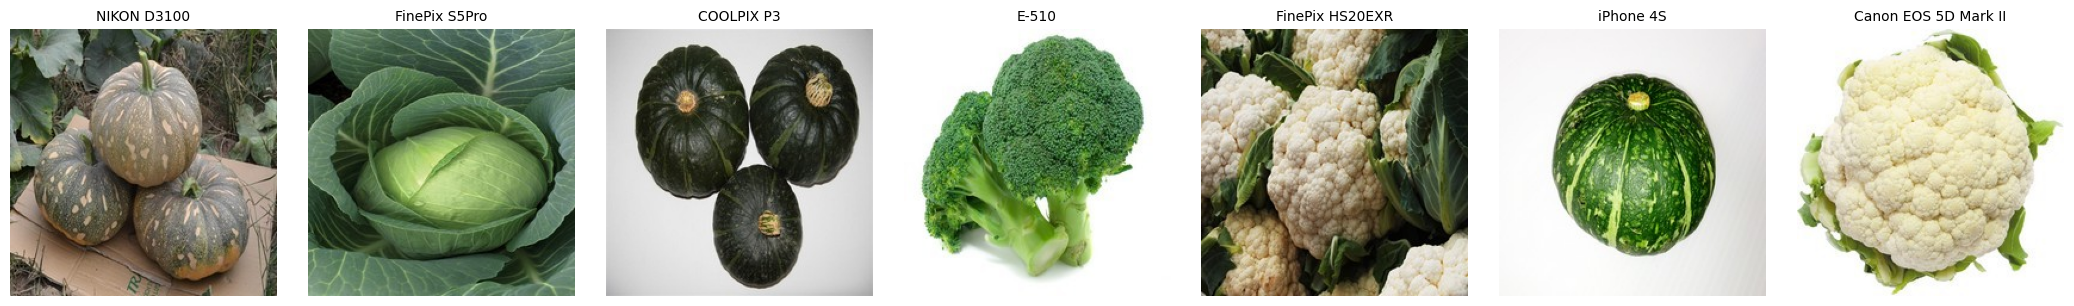

In [76]:
models = random.sample(list(exif_df["model"].dropna().unique()), 7)
fig, axes = plt.subplots(1, 7, figsize=(21, 3))

for i, model in enumerate(models):
    row = exif_df[exif_df["model"] == model].iloc[0]
    img_class_path = os.path.join(DATASET_DIR, row["class"])
    img_path = os.path.join(img_class_path, row["name"])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(model, fontsize=10)
plt.tight_layout()
plt.show()

Качество изображений отличается в зависимости от камеры.

**У изображений встречаются EXIF-данные, в дальнейшем их можно будет использовать как дополнительные признаки для улучшения модели**

## 3. Изучение связи изображений с целевой переменной

Визуально проанализируем несколько примеров изображений из каждого класса, чтобы лучше понять взаимосвязь между изображением и целевой переменной

In [77]:
# Функция для отображения нескольких изображений из класса
def show_images(folder_path, cls, num_images=5):
    image_files = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.show()

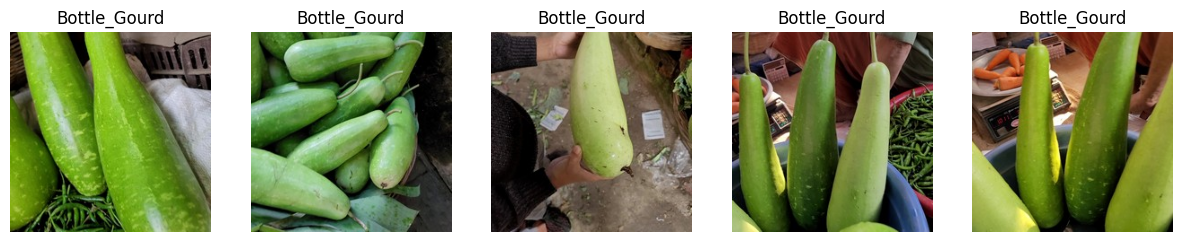

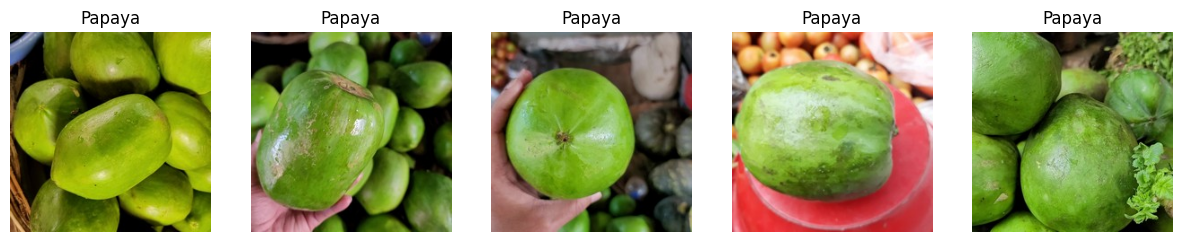

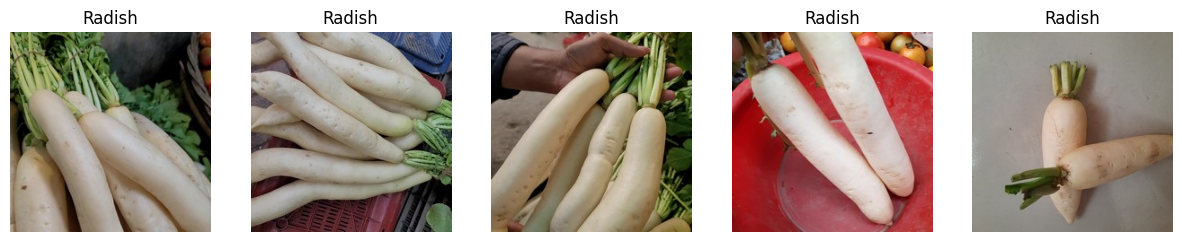

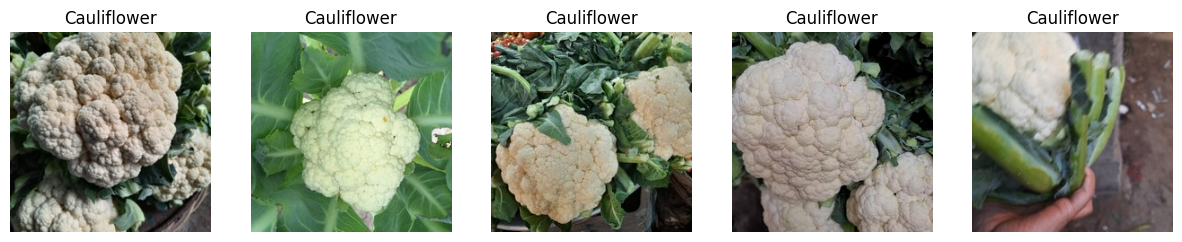

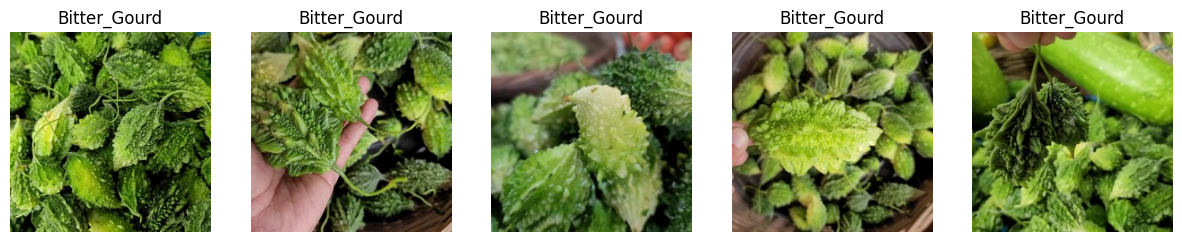

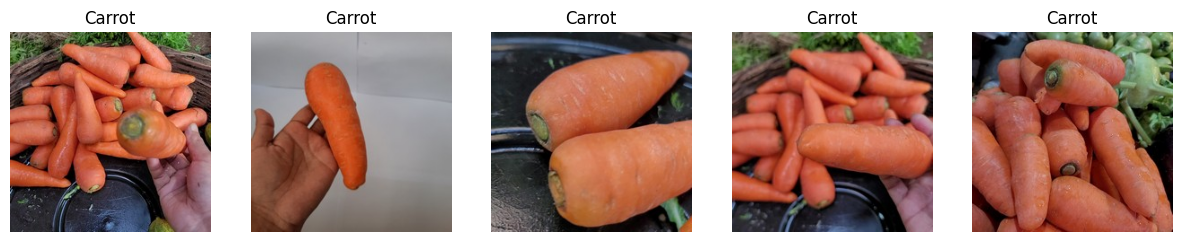

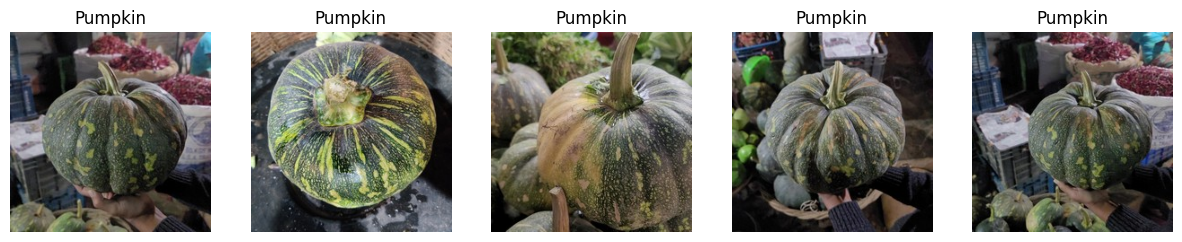

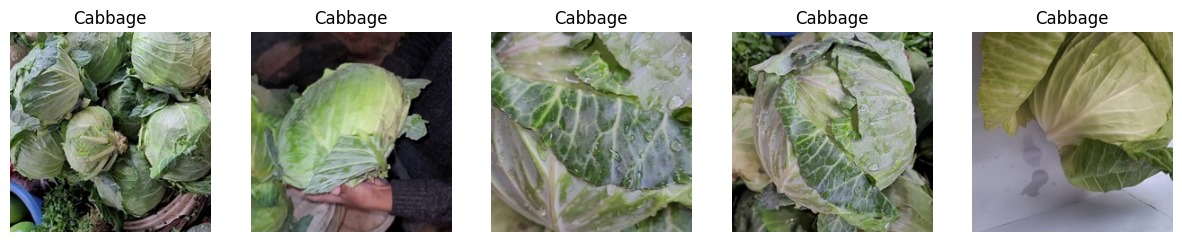

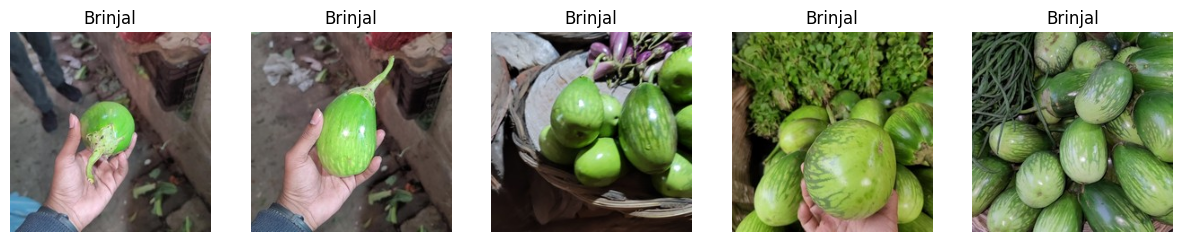

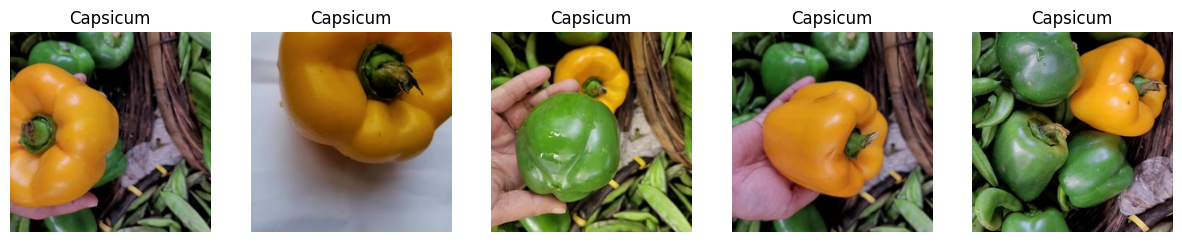

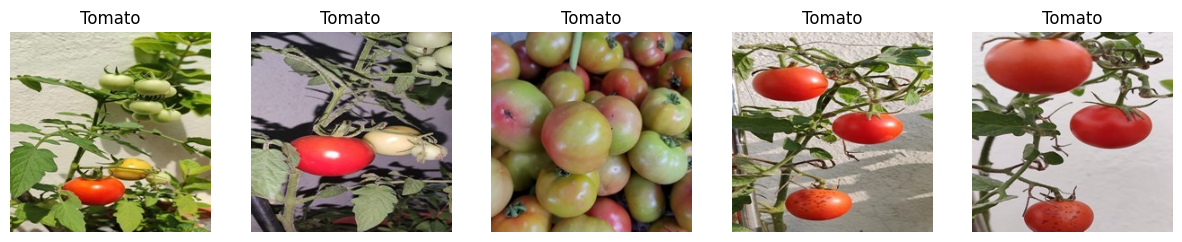

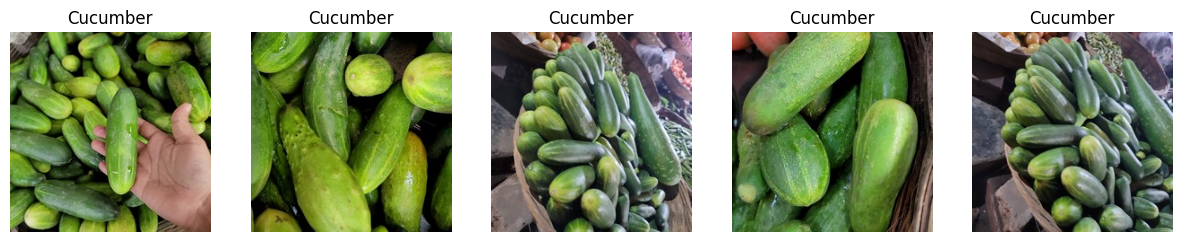

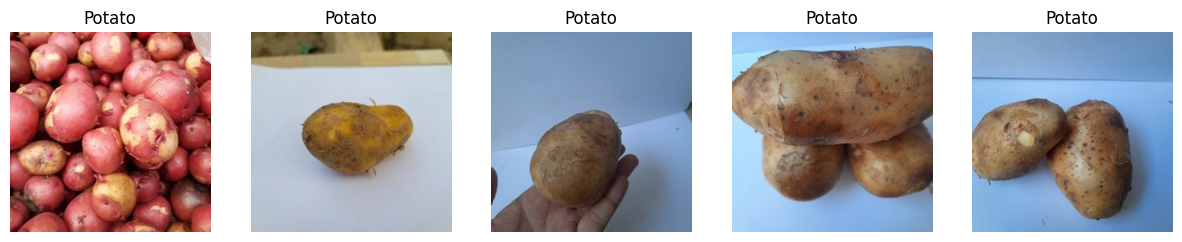

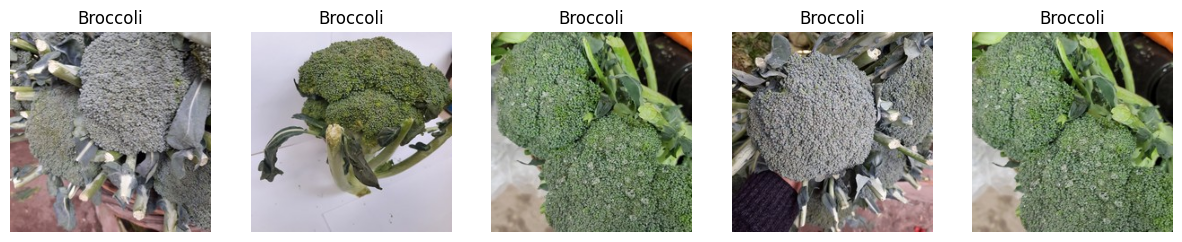

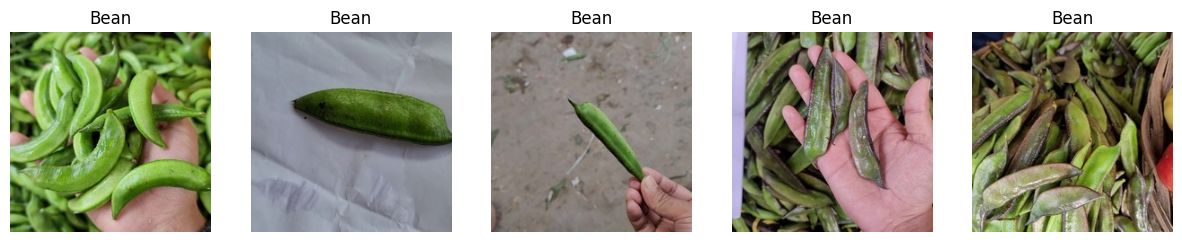

In [78]:
for cls in classes:
    folder_path = os.path.join(DATASET_DIR, cls)
    show_images(folder_path, cls)

Для класса **Tomato**:  
Большая часть изображений в данном классе растянуты и сплюснуты.

Для класса **Radish**:  
Редис на изображениях светлый и вытянутый. Так же бывает круглый и красный редис, но в датасете такие не представлены

Для класса **Brinjal**:  
Все баклажаны в датасете зеленого цвета. Баклажаны чаще встречаются фиолетового цвета, в датасете не представлены.

Для класса **Pumpkin**:  
Тыквы в датасете все одинакового цвета, больше похожи на арбуз. Тыквы часто бывают рыжего цвета, но в датасете не представлены

Остальные классы в датасете выглядят удовлетворительно.

## 4. Визуализация данных

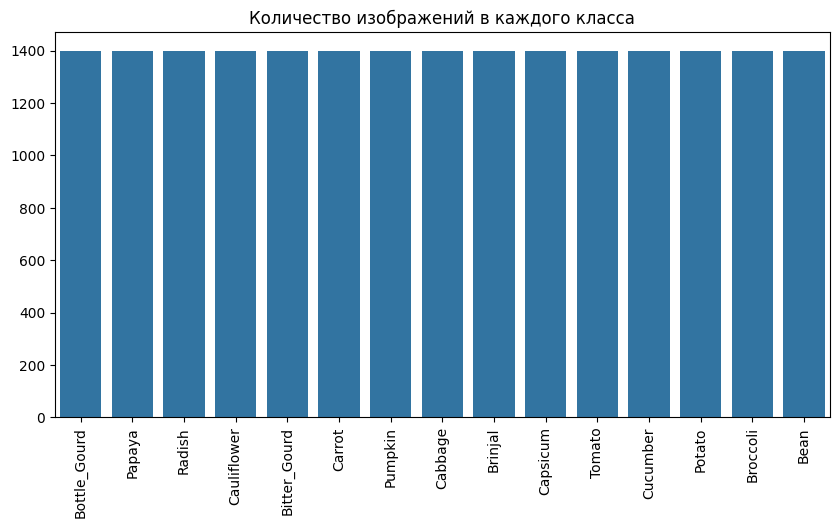

In [79]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждого класса")
plt.show()

**Для каждого класса представлено 1400 изображений. Датасет хорошо сбалансирован.**

## 5. Первичная предобработка изображений

### Определение размера для ресайза или нарезки изображений

In [80]:
# DataFrame с информацией о картинках с нестандартным размером
incorrect_sized = df.loc[(df["width"] != 224) | (df["height"] != 224)]
incorrect_sized.head()

class      name  width  height
1411  Papaya  0741.jpg    224     210
1774  Papaya  0126.jpg    224     211
1885  Papaya  1246.jpg    224     207
2148  Papaya  1150.jpg    224     223
2687  Papaya  1138.jpg    224     187

Т.к. есть изображения нестандартного размера, то можно привести их к одному размеру. Ранее было принято решение использовать оптимальный размер 224*224px.

In [81]:
def set_image_size(img_path: str, size: tuple[int, int]):
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color="white", centering=(0.5, 0.5))
    img_padded.save(img_path)

In [82]:
for row in incorrect_sized.values:
    path = os.path.join(DATASET_DIR, row[0], row[1])
    set_image_size(path, (224, 224))

In [83]:
row_list = []
for cls in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cls)
    row_list.extend(check_image_sizes(folder_path, cls))

  0%|          | 0/15 [00:00<?, ?it/s]

In [84]:
df = pd.DataFrame(row_list, columns=["class", "name", "width", "height"])
df.describe()

width   height
count  21000.0  21000.0
mean     224.0    224.0
std        0.0      0.0
min      224.0    224.0
25%      224.0    224.0
50%      224.0    224.0
75%      224.0    224.0
max      224.0    224.0

Ункция ресайза корректно отработала, все изображения приведены к единому размеру. В дальнейшей работе можно будет использовать эту функции для подготовки изображений.